In [1]:
using Pkg
using DifferentialEquations
using OrdinaryDiffEq, CuArrays, LinearAlgebra
using DynamicalSystems
using Distributions, StatsBase
using NPZ
using PyPlot
pyplot() # change backend to pyplot

LoadError: UndefVarError: pyplot not defined

#### define BWR model

In [2]:
function BWR!(dx, x, p, t)
    # x[1] = n, x[2]=c, x[3]=T, x[4]=ρₐ, x[5] = ̇ρₐ
    #n,c,T,ρₐ,̇   ρdₐ= x
    #n,c,T,ρₐ,̇ ρdₐ= x
    n,c,T,ρₐ,dρₐ = x
    a₁,a₂,a₃,a₄,Λ,λ,β,D,k = p
    dx[1] = -β/Λ*n + λ*c + D/Λ*T + 1/Λ*ρₐ+1/Λ*n*ρₐ + D/Λ*T*n
    dx[2] = β/Λ*n - λ*c 
    dx[3] = a₁*n - a₂*T
    #dx[4] = ̇ρₐ
    dx[4] = dρₐ
    #dx[5] = k*T -a₃*̇ρₐ-a₄*ρₐ
    dx[5] = k*T -a₃*dρₐ-a₄*ρₐ
end

BWR! (generic function with 1 method)

##### define initial condition, parameters and problem

In [3]:
x0 = [0.1, 0, 0, 0, 0]
p = [25.04, 0.23, 2.25, 6.82, 4e-5, 0.08, 0.0056, -2.61e-5, -7.2e-3]
tspan = (0.0, 600.0)
prob = ODEProblem(BWR!, x0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 600.0)
u0: [0.1, 0.0, 0.0, 0.0, 0.0]

##### solve problem

In [4]:
sol = solve(prob);

##### Analyzing the solution
- the solution type has two important fields: *u* and _t_
- access the 5th value of the solution: sol[5]
- access the 5th component of the solution at time step 6: sol[5,6], or sol[5][6]. Julia is column-major
- access ith component timeseries: sol[i,:]
- get the time of the 8th timestep: sol.t[8]
- access the interpolated values by treating sol as a function: sol(0.5), it is ok if t is a vector. Option:idxs= the index of the components to do interpolation.

##### sampling the result at different sampling rate

In [5]:
# drop initial half time span
t_start = tspan[2] / 2

# define sampling rate #/s
sr_1 = 1
sr_2 = 2
sr_3 = 5
sr_4 = 10
sr_5 = 20
sr_6 = 50
sr_7 = 100
sr = [sr_1, sr_2, sr_3, sr_4, sr_5, sr_6, sr_7]

t_1 = Array(t_start:1 / sr_1:tspan[2])
t_2 = Array(t_start:1 / sr_2:tspan[2])
t_3 = Array(t_start:1 / sr_3:tspan[2])
t_4 = Array(t_start:1 / sr_4:tspan[2])
t_5 = Array(t_start:1 / sr_5:tspan[2])
t_6 = Array(t_start:1 / sr_6:tspan[2])
t_7 = Array(t_start:1 / sr_7:tspan[2])

t_0 = filter(x->x>=300, sol.t)
sol_0 = sol(t_0)
sol_1 = sol(t_1)
sol_2 = sol(t_2)
sol_3 = sol(t_3)
sol_4 = sol(t_4)
sol_5 = sol(t_5)
sol_6 = sol(t_6)
sol_7 = sol(t_7)

sols = [sol_0, sol_1, sol_2, sol_3, sol_4, sol_5, sol_6, sol_7];

##### plot results

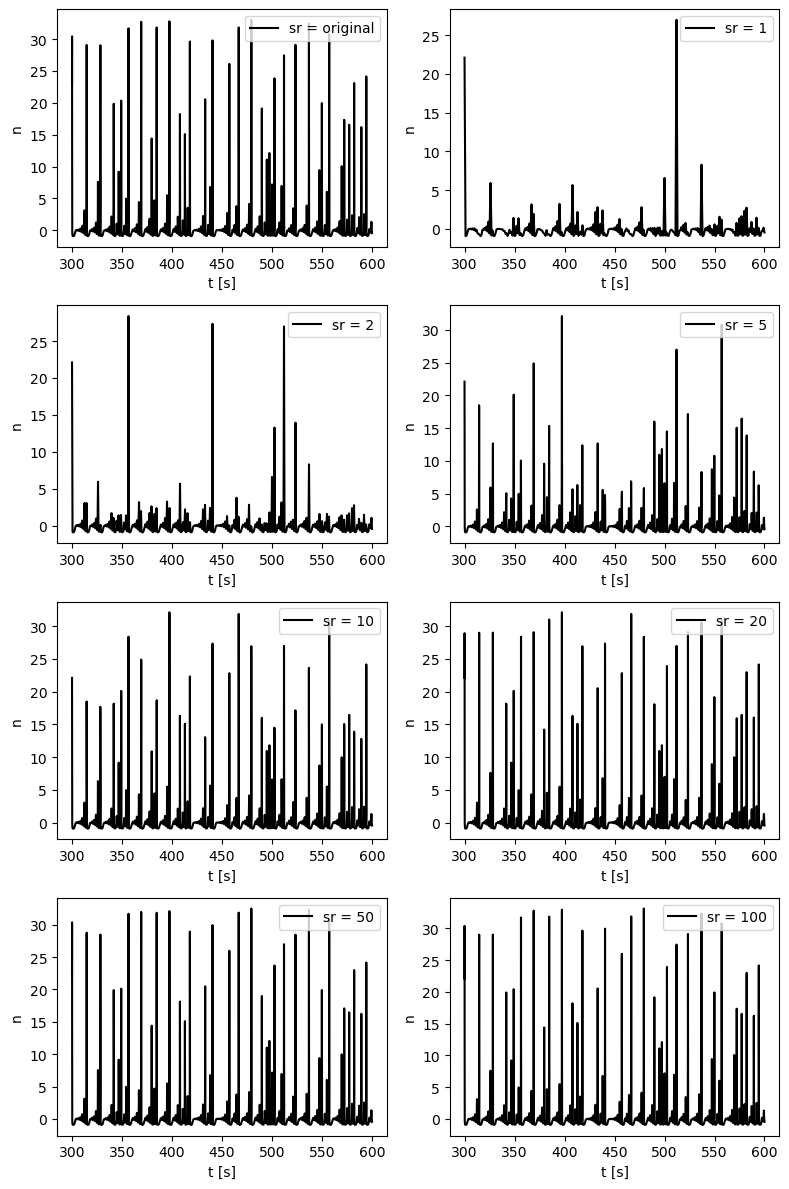

In [54]:
sr_plus = Array{Any}(undef, length(sols) + 1)
sr_plus[1] = "original"
sr_plus[2:8] = sr
fig, axs = PyPlot.subplots(4, 2,figsize = (8,12))

#axs[1].plot(sols[1].t,sols[1][1,:], color = "black",label = "sr = $(sr_plus[i])")
for i in 1:2
    axs[1,i].plot(sols[i].t,sols[i][1,:], color = "black",label = "sr = $(sr_plus[i])")
    axs[1,i].legend(loc = "upper right")
    axs[1,i].set_xlabel("t [s]")
    axs[1,i].set_ylabel("n")
end

for i in 1:2
    axs[2,i].plot(sols[i+2].t,sols[i+2][1,:], color = "black",label = "sr = $(sr_plus[i+2])")
    axs[2,i].legend(loc = "upper right")
    axs[2,i].set_xlabel("t [s]")
    axs[2,i].set_ylabel("n")
end

for i in 1:2
    axs[3,i].plot(sols[i+4].t,sols[i+4][1,:], color = "black",label = "sr = $(sr_plus[i+4])")
    axs[3,i].legend(loc = "upper right")
    axs[3,i].set_xlabel("t [s]")
    axs[3,i].set_ylabel("n")
end

for i in 1:2
    axs[4,i].plot(sols[i+6].t,sols[i+6][1,:], color = "black",label = "sr = $(sr_plus[i+6])")
    axs[4,i].legend(loc = "upper right")
    axs[4,i].set_xlabel("t [s]")
    axs[4,i].set_ylabel("n")
end

PyPlot.tight_layout()

#PyPlot.savefig(r"C:\\Users\xxc90\Desktop\phm08-project\BWR_dynamic_plot.png", dpi = 300)
savefig("BWR_dynamic_plot.png", dpi = 300)

##### Chaos game representation

In [7]:
function chaos_game(pos, symbol)
        pos1 = [-1., 0.]
        pos2 = [1., 0.]
        pos3 = [0., sqrt(3)]
        if symbol == 1
            pos = (pos + pos1) ./ 2
        elseif symbol == 2
            pos = (pos + pos2) ./ 2
        else
            pos = (pos+pos3) ./ 2
        end
end

chaos_game (generic function with 1 method)

##### create background sierpinski gasket

In [8]:
n = 200000
y0 = sample(1:3, n)
poss0 = zeros(Float64, n, 2)
for i in 2:n
    poss0[i,:] = chaos_game(poss0[i-1,:], y0[i])
end

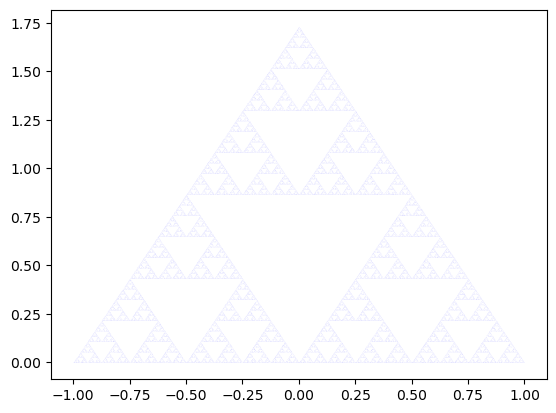

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000065FB37F0>

In [9]:
PyPlot.plot(poss0[:,1], poss0[:,2], ls = "None", ms = 0.5, color = "blue", marker = "o", alpha = 0.005)

##### data normalization

In [10]:
sol_0_nmlz = sol(t_0)[1,:]
sol_1_nmlz = sol(t_1)[1,:]
sol_2_nmlz = sol(t_2)[1,:]
sol_3_nmlz = sol(t_3)[1,:]
sol_4_nmlz = sol(t_4)[1,:]
sol_5_nmlz = sol(t_5)[1,:]
sol_6_nmlz = sol(t_6)[1,:]
sol_7_nmlz = sol(t_7)[1,:]

sols_nmlz = [sol_0_nmlz, sol_1_nmlz, sol_2_nmlz, sol_3_nmlz, sol_4_nmlz, sol_5_nmlz, sol_6_nmlz, sol_7_nmlz]

for i in 1:8
    min = minimum(sols_nmlz[i])
    max = maximum(sols_nmlz[i])
    sols_nmlz[i] = (sols_nmlz[i] .- min) ./ (max - min)
end

##### convert value to moving direction

In [11]:
for i in 1:8
    sols_nmlz[i][sols_nmlz[i] .> 2/3 ] .= 3
    sols_nmlz[i][1/3 .<= sols_nmlz[i] .<= 2/3] .= 2
    sols_nmlz[i][sols_nmlz[i] .< 1/3 ] .= 1
end

##### chaos game representation

In [22]:
poss1 = []
for i in 1:8
    #poss1_i = Array{Float64}(undef,length(sols_nmlz[i]),2)
    poss1_i = zeros(Float64, length(sols_nmlz[i]),2)
    for j in 2:length(sols_nmlz[i])
        poss1_i[j,:] = chaos_game(poss1_i[j-1,:], sols_nmlz[i][j-1])
    end
    push!(poss1, poss1_i)
    println(i)
end

1
2
3
4
5
6
7
8


##### plot the CGR results

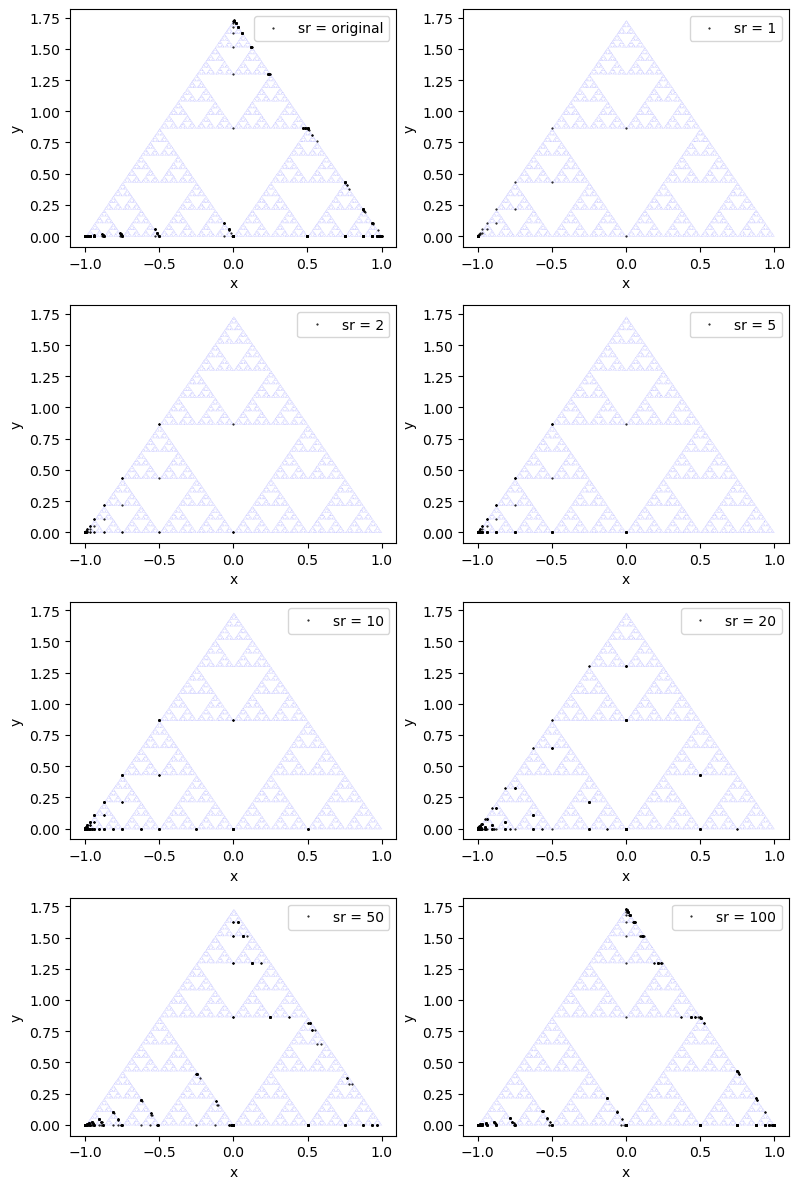

In [58]:
fig, axs = PyPlot.subplots(4, 2,figsize = (8,12))

for i in 1:2
    axs[1,i].plot(poss0[:,1], poss0[:,2], ls = "None", ms = 0.5, color = "blue", marker = "o", alpha = 0.005)
    axs[1,i].plot(poss1[i][:,1], poss1[i][:,2], ls = "None", ms = 0.5, color = "black", marker = "o", alpha = 1, label = "sr = $(sr_plus[i])")
    axs[1,i].legend(loc = "upper right")
    axs[1,i].set_xlabel("x")
    axs[1,i].set_ylabel("y")
end

for i in 1:2
    axs[2,i].plot(poss0[:,1], poss0[:,2], ls = "None", ms = 0.5, color = "blue", marker = "o", alpha = 0.005)
    axs[2,i].plot(poss1[i+2][:,1], poss1[i+2][:,2], ls = "None", ms = 0.5, color = "black", marker = "o", alpha = 1, label = "sr = $(sr_plus[i+2])")
    axs[2,i].legend(loc = "upper right")
    axs[2,i].set_xlabel("x")
    axs[2,i].set_ylabel("y")
end

for i in 1:2
    axs[3,i].plot(poss0[:,1], poss0[:,2], ls = "None", ms = 0.5, color = "blue", marker = "o", alpha = 0.005)
    axs[3,i].plot(poss1[i+4][:,1], poss1[i+4][:,2], ls = "None", ms = 0.5, color = "black", marker = "o", alpha = 1, label = "sr = $(sr_plus[i+4])")
    axs[3,i].legend(loc = "upper right")
    axs[3,i].set_xlabel("x")
    axs[3,i].set_ylabel("y")
end

for i in 1:2
    axs[4,i].plot(poss0[:,1], poss0[:,2], ls = "None", ms = 0.5, color = "blue", marker = "o", alpha = 0.005)
    axs[4,i].plot(poss1[i+6][:,1], poss1[i+6][:,2], ls = "None", ms = 0.5, color = "black", marker = "o", alpha = 1, label = "sr = $(sr_plus[i+6])")
    axs[4,i].legend(loc = "upper right")
    axs[4,i].set_xlabel("x")
    axs[4,i].set_ylabel("y")
end

PyPlot.tight_layout()
savefig("BWR_Seipinski_plot.png", dpi = 300)